## Selecting targets for visual re-inspection
### ELGs - tile 67230

This notebook will merge the truth tables with Andes redrock files and select targets that need to be re-inspected, according to the following criteria:

- Redrock z changed between original and new;
- Redrock chisq or delta chisq changed by a large amount.
- New Redrock z disagrees with visual inspections;
- New Redrock Spec type differs from VI;
- The VI flag was < 2.5. **N.B: I changed this to <= 2.5**


In [2]:
import os, sys, glob
import numpy as np

from astropy.io import fits
from astropy.table import Table, join, vstack
from astropy.io import fits

import pandas as pd
import fnmatch

import desispec.io

sys.path.append("/global/homes/r/rtojeiro/SV/python")
import VI_utils as VI

import matplotlib.pyplot as plt 

pd.set_option('display.max_rows', 50)

In [3]:
tiledir_andes='/global/cfs/cdirs/desi/spectro/redux/andes/tiles/'
tiledir = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'
tile = '67230'
date = '20200315'
spectrograph = ['0','1', '2', '3', '4', '5', '6' ,'7', '8', '9']

In [4]:
save_filename = 'ELG_reinspection_67230.csv'

### Read in truth table

In [5]:
full_filename = 'truth_table_ELG_v1.1_latest.csv'
truth_table = pd.read_csv(os.environ['TT_DIR']+'/'+full_filename)
#convert from pandas DataFrame to astropy Table for ease later
#truth_table = Table.from_pandas(df)

In [6]:
truth_table.keys()

Index(['Unnamed: 0', 'TARGETID', 'Redrock z', 'Redrock spectype', 'best z',
       'best spectype', 'best flag', 'N_VI', 'all VI issue', 'all VI comments',
       'merger comment', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z'],
      dtype='object')

First, add chi2 from the original reductions, as we never added that to the truth tables

In [7]:
#read in zbest info, loop over the files for all the spectrographs
tspec = Table.read(tiledir+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[0])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
for i in range(1,len(spectrograph)):
    tn = Table.read(tiledir+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[i])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
    tspec = vstack([tspec,tn])

tspec_df = tspec['TARGETID','CHI2'].to_pandas()

truth_table = truth_table.merge(tspec_df, how='left', on='TARGETID')

In [8]:
truth_table.keys()

Index(['Unnamed: 0', 'TARGETID', 'Redrock z', 'Redrock spectype', 'best z',
       'best spectype', 'best flag', 'N_VI', 'all VI issue', 'all VI comments',
       'merger comment', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2'],
      dtype='object')

Now add information from the Andes reductions: redshift, chi2, deltachi2, spectype and warning flags

In [9]:
#read in zbest info, loop over the files for all the spectrographs
tspec = Table.read(tiledir_andes+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[0])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
for i in range(1,len(spectrograph)):
    tn = Table.read(tiledir_andes+'/'+tile + '/'+date+'/zbest-'+str(spectrograph[i])+'-'+str(tile)+'-'+date+'.fits',hdu='ZBEST')
    tspec = vstack([tspec,tn])

tspec_df = tspec['TARGETID','Z','CHI2', 'DELTACHI2','ZWARN', 'ZERR', 'SPECTYPE' ].to_pandas()

tspec_df = tspec_df.rename(columns={"Z": "Z_andes"})
tspec_df = tspec_df.rename(columns={"CHI2": "CHI2_andes"})
tspec_df = tspec_df.rename(columns={"SPECTYPE": "SPECTYPE_andes"})

truth_table = truth_table.merge(tspec_df, how='left', on='TARGETID', suffixes=('', '_andes'))

In [10]:
truth_table.keys()

Index(['Unnamed: 0', 'TARGETID', 'Redrock z', 'Redrock spectype', 'best z',
       'best spectype', 'best flag', 'N_VI', 'all VI issue', 'all VI comments',
       'merger comment', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2',
       'Z_andes', 'CHI2_andes', 'DELTACHI2_andes', 'ZWARN_andes', 'ZERR_andes',
       'SPECTYPE_andes'],
      dtype='object')

Text(0,0.5,'DELTACHI Andes')

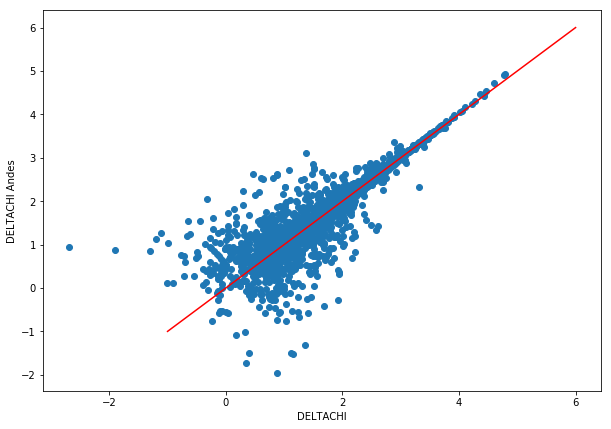

In [11]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['DELTACHI2']), np.log10(truth_table['DELTACHI2_andes']))
plt.plot([-1,6], [-1,6], color='red')
plt.xlabel('DELTACHI')
plt.ylabel('DELTACHI Andes')

Text(0,0.5,'DELTACHI Andes')

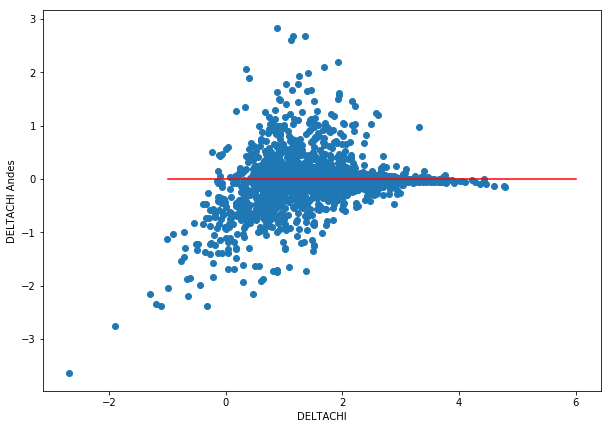

In [12]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['DELTACHI2']), 
    (np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes'])))
plt.plot([-1,6], [0,0], color='red')
plt.xlabel('DELTACHI')
plt.ylabel('DELTACHI Andes')

Text(0,0.5,'N')

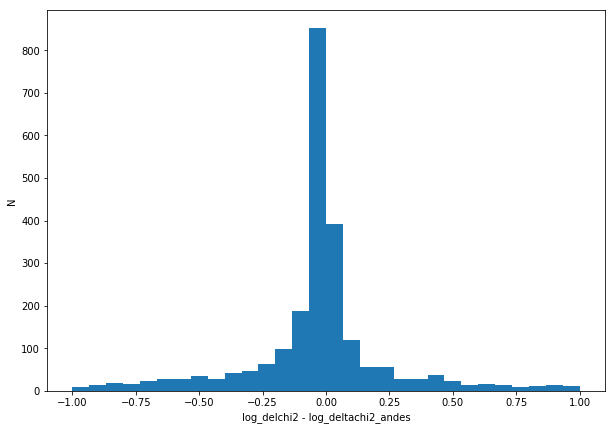

In [24]:
plt.figure(figsize=(10,7))
x=plt.hist(np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes']), bins=30,
            range=(-1,1))
plt.xlabel('log_delchi2 - log_deltachi2_andes')
plt.ylabel('N')

I'm going to include everything for which log10_deltachi2 changed by more than 0.25 in absolute value

Text(0,0.5,'log CHI2 Andes')

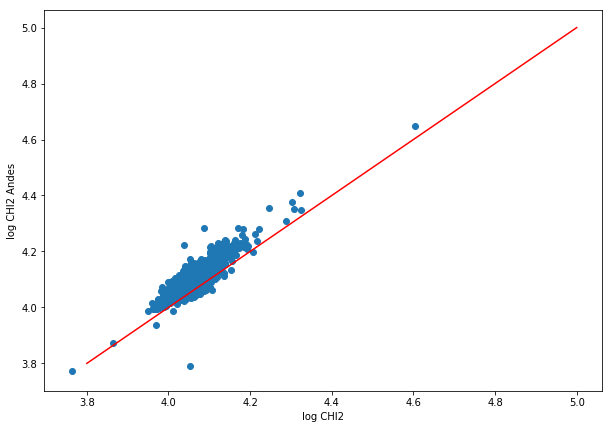

In [14]:
plt.figure(figsize=(10,7))
plt.scatter(np.log10(truth_table['CHI2']), np.log10(truth_table['CHI2_andes']))
plt.plot([3.8,5], [3.8,5], color='red')
plt.xlabel('log CHI2')
plt.ylabel('log CHI2 Andes')

Chi2 is generally higher in Andes, so I'm **not** going to include chi2 difference between original and Andes reductions in the criteria for re-inspection.

In [19]:
re_VI = truth_table[ \
            ((truth_table['Redrock z']-truth_table['Z_andes'])/(1+truth_table['Redrock z']) > 0.0033) | 
            ((truth_table['best z']-truth_table['Z_andes'])/(1+truth_table['best z']) > 0.0033) |
            (truth_table['best spectype'] != truth_table['SPECTYPE_andes']) |
            (truth_table['best flag'] <= 2.5) | 
            (np.abs(np.log10(truth_table['DELTACHI2'])-np.log10(truth_table['DELTACHI2_andes'])) > 0.1 )       
            ]
print(len(re_VI))

1250


In [20]:
re_VI.keys()

Index(['Unnamed: 0', 'TARGETID', 'Redrock z', 'Redrock spectype', 'best z',
       'best spectype', 'best flag', 'N_VI', 'all VI issue', 'all VI comments',
       'merger comment', 'DELTACHI2', 'ZWARN', 'ZERR', 'FIBER', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z',
       'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'CHI2',
       'Z_andes', 'CHI2_andes', 'DELTACHI2_andes', 'ZWARN_andes', 'ZERR_andes',
       'SPECTYPE_andes'],
      dtype='object')

In [22]:
re_VI[['best z', 'Redrock z', 'Z_andes', 'best flag', 'best spectype', 'SPECTYPE_andes', 'DELTACHI2', 'DELTACHI2_andes']]

,best z,Redrock z,Z_andes,best flag,best spectype,SPECTYPE_andes,DELTACHI2,DELTACHI2_andes
0,0.5481,0.5481,0.583852,0.333333,GALAXY,GALAXY,6.121645,3.583444
2,1.2095,1.2095,1.209518,2.000000,GALAXY,GALAXY,43.749015,91.443574
6,1.1293,1.1293,1.129337,3.666667,GALAXY,GALAXY,33.110367,70.876879
9,1.5280,1.5280,1.527994,1.000000,GALAXY,GALAXY,19.545464,17.223384
10,1.3827,1.3827,1.029140,0.333333,GALAXY,GALAXY,0.830912,1.845067
11,0.5312,0.5312,0.555416,1.000000,GALAXY,GALAXY,1.316707,6.337066
15,0.3384,0.3384,0.570643,0.333333,GALAXY,GALAXY,3.116829,13.144874
22,0.5646,0.5646,0.528818,0.333333,GALAXY,GALAXY,5.579757,2.098508
25,1.2374,1.2374,1.237440,2.000000,QSO,QSO,48.094389,60.527001
27,0.2956,0.2956,1.402978,0.333333,GALAXY,GALAXY,7.567056,25.686877


In [23]:
re_VI['TARGETID'].to_csv(os.environ['TT_DIR']+save_filename, index=False, header=False)